In [1]:
from transformers import Blip2Processor

# load the pretrain model?
checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

/home/duevano/miniconda3/envs/detectron2-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load BASE model hanya sekali
base_model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",  # sesuaikan dengan base dari semua peft_model_id kamu
    torch_dtype=torch.float16,
    cache_dir="./cache-blip2"
).to(device)


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.09it/s]


In [27]:
# Fungsi untuk switch adapter
def load_adapter(base_model, peft_model_id, device):
    model = PeftModel.from_pretrained(base_model, peft_model_id)
    model = model.to(device)
    return model

# Contoh penggunaan:
# Ganti adapter dengan cepat
peft_model_id_1 = "content/data/blip2_visual_model_1v2_nonpadded"
peft_model_id_2 = "content/data/blip2_visual_model_1v2"

# Ganti adapter sesuai kebutuhan
# model = load_adapter(base_model, peft_model_id_1, device)

# ... lakukan inferensi
model = load_adapter(base_model, peft_model_id_2, device)
# ... lakukan inferensi lagi

In [4]:
import pandas as pd

test_df = pd.read_parquet("test_data_processed.parquet")
test_df.head()

,id,title,image_name,category,color,clean_title,clean_color,caption
0,111132,lithos backpack,1916180f-3813-4938-a156-a138dd32b662.jpeg,backpack,Black,lithos backpack,black,black lithos backpack
1,115473,wring backpack,c355dd3e-5a13-486f-abfa-53105b8c6d63.jpeg,backpack,Gray X Purple,wring backpack,gray purple,gray purple wring backpack
2,116272,mini nova clear backpack,eae638c3-d430-4501-ae73-e85d0fb0b1ad.jpeg,backpack,Black Smoke,mini nova clear backpack,black smoke,black smoke mini nova clear backpack
3,110354,construct backpack,d5c1acd8-9421-4e2b-9e3a-0f6fd868b278.jpeg,backpack,Black,construct backpack,black,black construct backpack
4,118686,logo strap nylon backpack,e7516459-a5c4-40f2-a9ef-b32247641e12.jpeg,backpack,Black/ Black,logo strap nylon backpack,black black,black logo strap nylon backpack


Processing: inferenceblip2/c93432f9-ecd0-4ed1-9f29-6ebc218bf463.jpeg


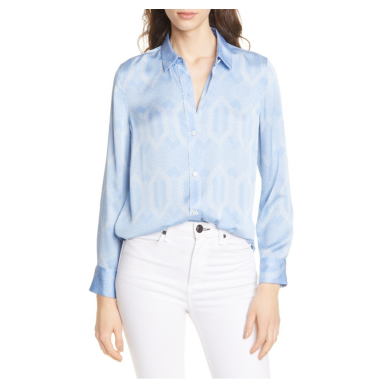

blue multi jacquard silk blouse


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 16
CAPTION_BATCH_SIZE = 32  # number of crops per batch for BLIP-2 inference


# img_path = "inferenceblip2/0a118c78-823e-4bdc-9951-b8e1ff737bd7.jpeg" # - CONTOH NETRAL (output sama)

# img_path = "inferenceblip2/435851fb-894a-4030-a981-afe9ad4c3502.jpeg" # - CONTOH ELEK di nonpadded, BAGUS di padded

# img_path = "inferenceblip2/aaa281f5-6603-4f5e-a7cc-6999359a2c70.jpeg" # - CONTOH ELEK di padded, BAGUS di nonpadded TAPI INI AKSESORIS

# img_path = "inferenceblip2/59f85034-bb26-4f49-9cfb-3d6f73260d72.jpeg" # - CONTOH ELEK di nonpadded, mendingan di padded

img_path = "inferenceblip2/c93432f9-ecd0-4ed1-9f29-6ebc218bf463.jpeg" # - CONTOH BAGUS


print(f"Processing: {img_path}")
image = Image.open(img_path)

# Buat subplot untuk menampilkan gambar beserta caption
fig, axes = plt.subplots(nrows=1, ncols=1)

# Persiapkan input untuk model (pindahkan ke device yang ditentukan)
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

# Hasilkan caption dengan model
generated_ids = model.generate(pixel_values=pixel_values, max_length=MAX_LENGTH)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Update DataFrame berdasarkan nama file
# df.loc[df["file_name"] == filename, "caption"] = generated_caption

# Tampilkan gambar beserta caption yang dihasilkan
axes.imshow(image)
axes.axis('off')  # Hilangkan axis
# axes.set_title(f"Generated: {generated_caption}", fontsize=14)
plt.show()
print(generated_caption)

In [26]:
image_name = img_path.replace("inferenceblip2/", "")
print("ground truth: ", test_df[test_df["image_name"]==image_name].caption)

ground truth:  460    della robbia blue aere leema button up blouse
Name: caption, dtype: object


In [29]:
# clear model dari gpu
# import torch
# import gc

# torch.cuda.empty_cache()
# gc.collect()
# del model

In [30]:
# with torch.no_grad():
#     torch.cuda.empty_cache()